# Project 3 Booking reviews

### Какой кейс решаем?
Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Признаки:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

### Файлы для соревнования

* hotels_train.csv - набор данных для обучения [источник данных](https://www.kaggle.com/competitions/sf-booking/data)
* hotels_test.csv - набор данных для оценки качества [источник данных](https://www.kaggle.com/competitions/sf-booking/data)
* submission.csv - файл сабмишна в нужном формате [источник данных](https://www.kaggle.com/competitions/sf-booking/data)


## 1. Исходные данные

In [5]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import category_encoders as ce

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
import string
import spacy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [6]:
N_THREADS = -1
N_FOLDS = 4
RANDOM_STATE = 42
TIMEOUT = 1500 # 25
TARGET_NAME = 'reviewer_score'

In [7]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')

In [8]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845,2.326
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,48.889,2.395
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,52.386,4.847


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Проведем проверку на дубликаты

In [10]:
dupl_columns = list(df_train.columns)
df_train = df_train.drop_duplicates(subset=dupl_columns)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 10  r

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [12]:
df_test.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.100,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533,9.171
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.600,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.386,4.834
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.300,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393,2.162


In [13]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [14]:
sample_submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


## EDA

In [15]:
df_train.isna().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

In [16]:
df_train['lat'] = df_train['lat'].fillna(df_train['lat'].median())
df_train['lng'] = df_train['lng'].fillna(df_train['lng'].median())

In [17]:
df_train.isna().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
dtype: int64

In [18]:
def clean_tags(tag_string):
    # Удаление квадратных скобок и лишних пробелов
    tag_string = tag_string.strip("[]")
    tag_list = tag_string.split(",")
    tag_list = [tag.strip(" '") for tag in tag_list]
    return tag_list

# Применение функции к столбцу 'tags'
df_train['tags'] = df_train['tags'].apply(clean_tags)

In [19]:
df_train['days_since_review'] = df_train['days_since_review'].str.replace(r'\D', '', regex=True).astype(int)

In [20]:
df_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[Leisure trip, Couple, Studio Suite, Stayed 2 nights, Submitted from a mobile device]",531,51.508,-0.144
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[Business trip, Couple, Standard Double Room, Stayed 1 night]",203,51.521,-0.123
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[Leisure trip, Solo traveler, Modern Double Room Echo, Stayed 3 nights, Submitted from a mobile device]",289,48.845,2.326


In [21]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring', 'days_since_review']

# категориальные признаки
cat_cols = ['average_score', 'lat']

In [22]:
X = df_train.drop(['reviewer_score'], axis = 1)  
y = df_train['reviewer_score'] 

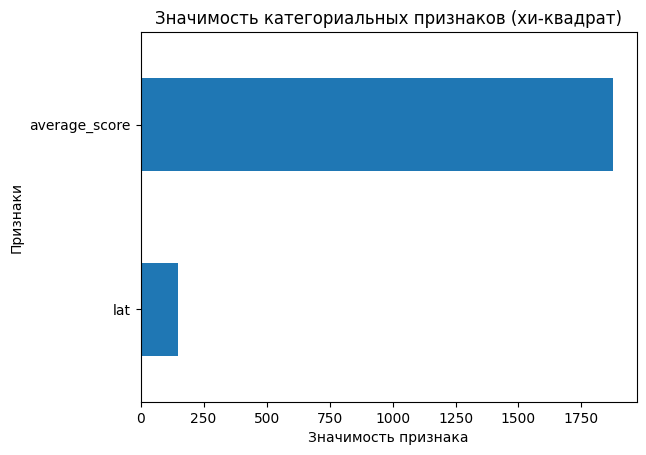

In [23]:
y=y.astype('int')
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Значимость категориальных признаков (хи-квадрат)')
plt.xlabel('Значимость признака')
plt.ylabel('Признаки')
plt.show()

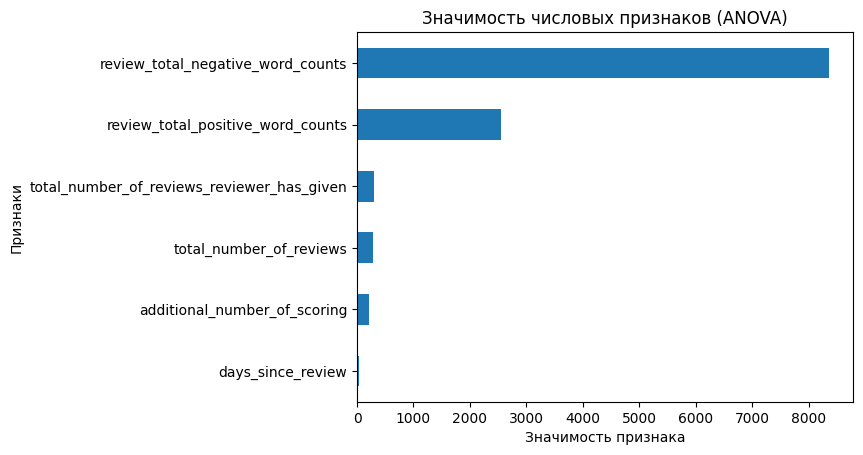

In [24]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', title='Значимость числовых признаков (ANOVA)')
plt.xlabel('Значимость признака')
plt.ylabel('Признаки')
plt.show()

In [25]:
df_train_clear = df_train.drop(['days_since_review', 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'tags'], axis=1)

In [26]:
df_train_clear.head(3)

,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,reviewer_score
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,Staff were amazing,4,10.000
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,location,2,6.300
2,151 bis Rue de Rennes 6th arr 75006 Paris France,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,No Positive,0,7.500


In [27]:
df_train_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386496 entries, 0 to 386802
Data columns (total 10 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   hotel_address                      386496 non-null  object 
 1   review_date                        386496 non-null  object 
 2   average_score                      386496 non-null  float64
 3   hotel_name                         386496 non-null  object 
 4   reviewer_nationality               386496 non-null  object 
 5   negative_review                    386496 non-null  object 
 6   review_total_negative_word_counts  386496 non-null  int64  
 7   positive_review                    386496 non-null  object 
 8   review_total_positive_word_counts  386496 non-null  int64  
 9   reviewer_score                     386496 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 32.4+ MB


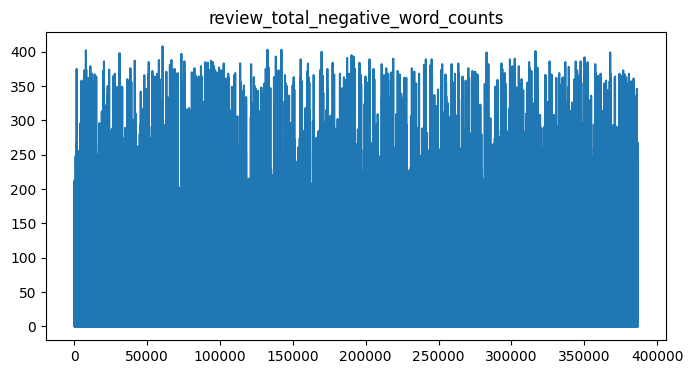

In [28]:
df_train_clear['review_total_negative_word_counts'].plot(kind='line', figsize=(8, 4), title='review_total_negative_word_counts')
plt.show()

## Преобразование данных и обучение модели

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [43]:
# Преобразование признаков с использованием Label Encoding для категориальных и TF-IDF для текстовых
label_enc = LabelEncoder()
df_train_clear['hotel_address'] = label_enc.fit_transform(df_train['hotel_address'])
df_train_clear['hotel_name'] = label_enc.fit_transform(df_train['hotel_name'])
df_train_clear['reviewer_nationality'] = label_enc.fit_transform(df_train['reviewer_nationality'])

# TF-IDF для текстовых полей
tfidf_negative = TfidfVectorizer(max_features=20)
tfidf_positive = TfidfVectorizer(max_features=20)
negative_tfidf = tfidf_negative.fit_transform(df_train['negative_review']).toarray()
positive_tfidf = tfidf_positive.fit_transform(df_train['positive_review']).toarray()

# Объединение всех признаков
df_transformed = pd.concat([df_train_clear.drop(['negative_review', 'positive_review'], axis=1), 
                            pd.DataFrame(negative_tfidf, columns=[f'negative_tfidf_{i}' for i in range(negative_tfidf.shape[1])]),
                            pd.DataFrame(positive_tfidf, columns=[f'positive_tfidf_{i}' for i in range(positive_tfidf.shape[1])])], axis=1)

In [44]:
df_transformed.head(3)

,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,review_total_positive_word_counts,reviewer_score,negative_tfidf_0,negative_tfidf_1,...,positive_tfidf_10,positive_tfidf_11,positive_tfidf_12,positive_tfidf_13,positive_tfidf_14,positive_tfidf_15,positive_tfidf_16,positive_tfidf_17,positive_tfidf_18,positive_tfidf_19
0,1310.000,2/19/2016,8.400,1366.000,213.000,3.000,4.000,10.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.565,0.000,0.000,0.000,0.000,0.825
1,126.000,1/12/2017,8.300,975.000,213.000,3.000,2.000,6.300,0.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,170.000,10/18/2016,8.900,909.000,42.000,6.000,0.000,7.500,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [45]:
df_transformed.isna().sum()

hotel_address                        307
review_date                          307
average_score                        307
hotel_name                           307
reviewer_nationality                 307
review_total_negative_word_counts    307
review_total_positive_word_counts    307
reviewer_score                       307
negative_tfidf_0                     307
negative_tfidf_1                     307
negative_tfidf_2                     307
negative_tfidf_3                     307
negative_tfidf_4                     307
negative_tfidf_5                     307
negative_tfidf_6                     307
negative_tfidf_7                     307
negative_tfidf_8                     307
negative_tfidf_9                     307
negative_tfidf_10                    307
negative_tfidf_11                    307
negative_tfidf_12                    307
negative_tfidf_13                    307
negative_tfidf_14                    307
negative_tfidf_15                    307
negative_tfidf_1

In [46]:
df_transformed = df_transformed.dropna()

In [47]:
df_transformed['review_date'] = pd.to_datetime(df_transformed['review_date'], errors='coerce')

# Проверка на наличие недопустимых значений после преобразования
if df_transformed['review_date'].isnull().any():
    print("Есть некорректные значения даты, проверьте данные!")

In [48]:
# Создание новых признаков: год, месяц, день
df_transformed.loc[:, 'review_year'] = df_transformed['review_date'].dt.year
df_transformed.loc[:, 'review_month'] = df_transformed['review_date'].dt.month
df_transformed.loc[:, 'review_day'] = df_transformed['review_date'].dt.day

df_transformed = df_transformed.drop('review_date', axis=1)

In [45]:
X = df_transformed.drop(['reviewer_score'], axis = 1)  
y = df_transformed['reviewer_score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  
# Создаём модель  
regr = model = RandomForestRegressor(
    n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=42)

In [46]:
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
       
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [47]:
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred) * 100)

MAPE: 13.652828174839621


## Попробуем добавить признаков и составить гипотезы

### Добавление новых признаков
#### Обоснование:

1. **Sentiment Analysis (Анализ тональности)**:
   - **negative_review_sentiment** и **positive_review_sentiment** предоставляют информацию о настроении отзывов, что помогает модели лучше понять, как сильно пользователь удовлетворен или недоволен.

2. **Text Features (Текстовые признаки)**:
   - **negative_review_length** и **positive_review_length** показывают, насколько подробно пользователи описывают свои впечатления, что может быть полезным индикатором интенсивности их чувств.

3. **Temporal Features (Временные признаки)**:
   - **review_year** и **review_month** помогают учесть временные тренды, такие как сезонные колебания в отзывах.

4. **Reviewer Information (Информация о рецензенте)**:
   - **reviewer_nationality_encoded** учитывает культурные различия, которые могут влиять на оценку отелей.


In [49]:
df_train_clear = df_train.drop(['days_since_review', 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'tags'], axis=1)

In [50]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_train_clear['negative_review_sentiment'] = df_train_clear['negative_review'].apply(get_sentiment)
df_train_clear['positive_review_sentiment'] = df_train_clear['positive_review'].apply(get_sentiment)

df_train_clear['negative_review_length'] = df_train_clear['negative_review'].apply(len)
df_train_clear['positive_review_length'] = df_train_clear['positive_review'].apply(len)

In [51]:
df_train_clear.head(3)

,hotel_address,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,reviewer_score,negative_review_sentiment,positive_review_sentiment,negative_review_length,positive_review_length
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,Staff were amazing,4,10.000,0.000,0.600,9,19
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,location,2,6.300,-0.400,0.000,15,9
2,151 bis Rue de Rennes 6th arr 75006 Paris France,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,No Positive,0,7.500,0.000,-0.114,19,11


In [52]:
df_train_clear['review_date'] = pd.to_datetime(df_train_clear['review_date'], errors='coerce')

In [53]:
df_train_clear['review_year'] = df_train_clear['review_date'].dt.year
df_train_clear['review_month'] = df_train_clear['review_date'].dt.month

label_encoder_nationality = LabelEncoder()

df_train_clear['reviewer_nationality_encoded'] = label_encoder_nationality.fit_transform(df_train_clear['reviewer_nationality'])

# Удаление старых ненужных признаков
df_train_clear.drop(columns=['negative_review', 'positive_review', 'hotel_address', 'review_date', 'reviewer_nationality'], inplace=True)

In [54]:
df_train_clear.head(3)

,average_score,hotel_name,review_total_negative_word_counts,review_total_positive_word_counts,reviewer_score,negative_review_sentiment,positive_review_sentiment,negative_review_length,positive_review_length,review_year,review_month,reviewer_nationality_encoded
0,8.400,The May Fair Hotel,3,4,10.000,0.000,0.600,9,19,2016,2,213
1,8.300,Mercure London Bloomsbury Hotel,3,2,6.300,-0.400,0.000,15,9,2017,1,213
2,8.900,Legend Saint Germain by Elegancia,6,0,7.500,0.000,-0.114,19,11,2016,10,42


In [55]:
df_train_clear.drop(columns=['hotel_name'], inplace=True)

In [56]:
df_train_clear.head(3)

,average_score,review_total_negative_word_counts,review_total_positive_word_counts,reviewer_score,negative_review_sentiment,positive_review_sentiment,negative_review_length,positive_review_length,review_year,review_month,reviewer_nationality_encoded
0,8.400,3,4,10.000,0.000,0.600,9,19,2016,2,213
1,8.300,3,2,6.300,-0.400,0.000,15,9,2017,1,213
2,8.900,6,0,7.500,0.000,-0.114,19,11,2016,10,42


### Вопросы

Прежде чем составлять графики и проверять гипотезы, важно задать правильные вопросы, которые мы хотим исследовать с использованием наших данных. Вот несколько вопросов, которые могут быть интересны:

1. **Есть ли связь между длиной отзыва и оценкой пользователя?**
2. **Как тональность отзывов влияет на оценку пользователя?**
3. **Меняется ли средняя оценка по месяцам и годам?**
4. **Влияет ли национальность рецензента на его оценку?**

### 1. Связь между длиной отзыва и оценкой пользователя

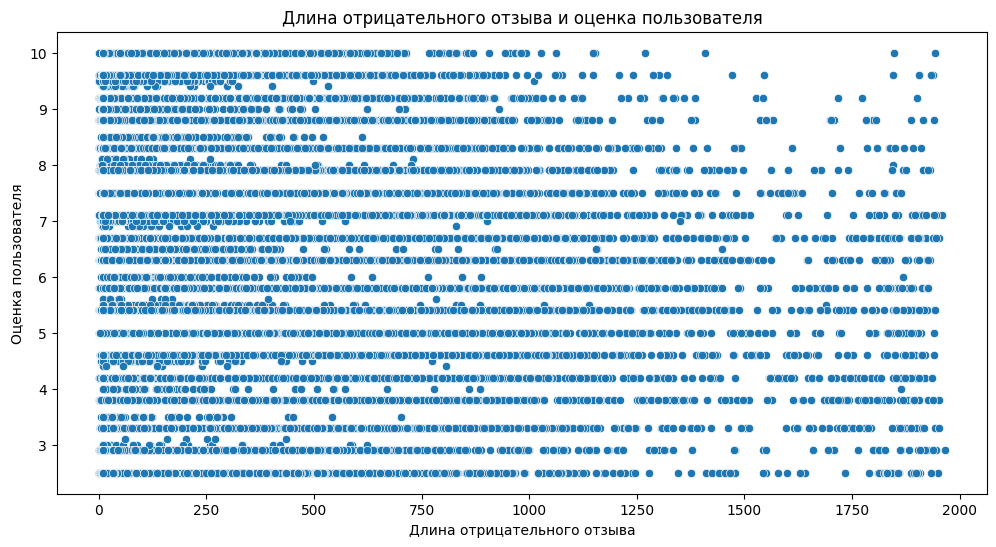

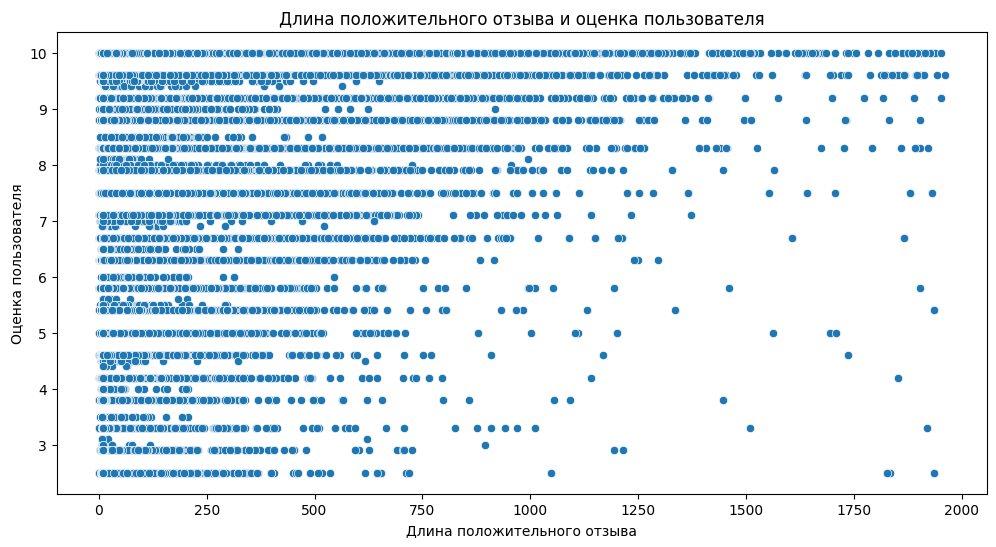

In [57]:
# Длина отрицательного отзыва и оценка пользователя
plt.figure(figsize=(12, 6))
sns.scatterplot(x='negative_review_length', y='reviewer_score', data=df_train_clear)
plt.title('Длина отрицательного отзыва и оценка пользователя')
plt.xlabel('Длина отрицательного отзыва')
plt.ylabel('Оценка пользователя')
plt.show()

# Длина положительного отзыва и оценка пользователя
plt.figure(figsize=(12, 6))
sns.scatterplot(x='positive_review_length', y='reviewer_score', data=df_train_clear)
plt.title('Длина положительного отзыва и оценка пользователя')
plt.xlabel('Длина положительного отзыва')
plt.ylabel('Оценка пользователя')
plt.show()

Исходя из графиков трудно пока что сделать вывод, но для положительных как будто чем длинее тем лучше оценка

### 2. Как тональность отзывов влияет на оценку пользователя?

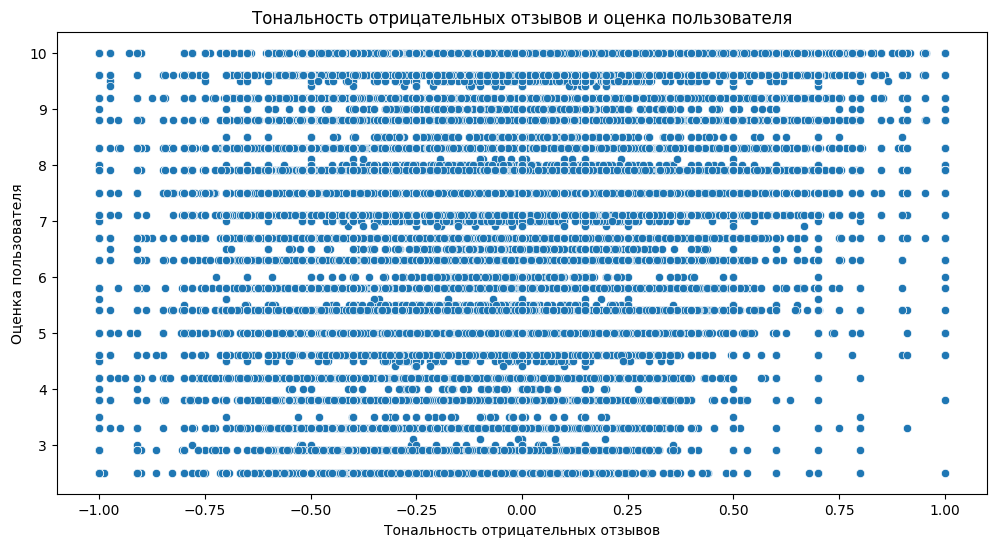

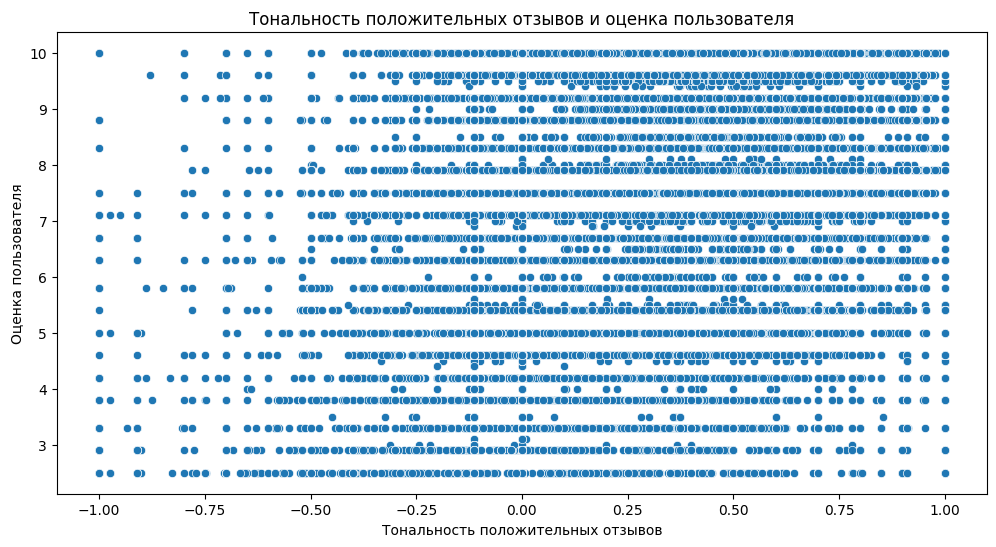

In [58]:
# Тональность отрицательных отзывов и оценка пользователя
plt.figure(figsize=(12, 6))
sns.scatterplot(x='negative_review_sentiment', y='reviewer_score', data=df_train_clear)
plt.title('Тональность отрицательных отзывов и оценка пользователя')
plt.xlabel('Тональность отрицательных отзывов')
plt.ylabel('Оценка пользователя')
plt.show()

# Тональность положительных отзывов и оценка пользователя
plt.figure(figsize=(12, 6))
sns.scatterplot(x='positive_review_sentiment', y='reviewer_score', data=df_train_clear)
plt.title('Тональность положительных отзывов и оценка пользователя')
plt.xlabel('Тональность положительных отзывов')
plt.ylabel('Оценка пользователя')
plt.show()

Также трудно сказать. Но в отрицательных много точек в середине или ближе к плохим

### 3. Меняется ли средняя оценка по месяцам и годам?

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


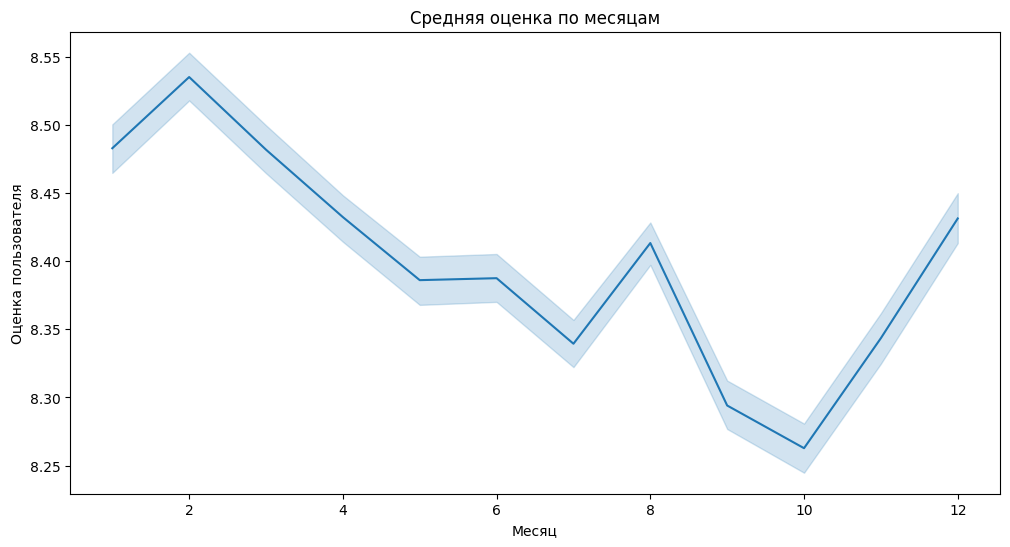

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


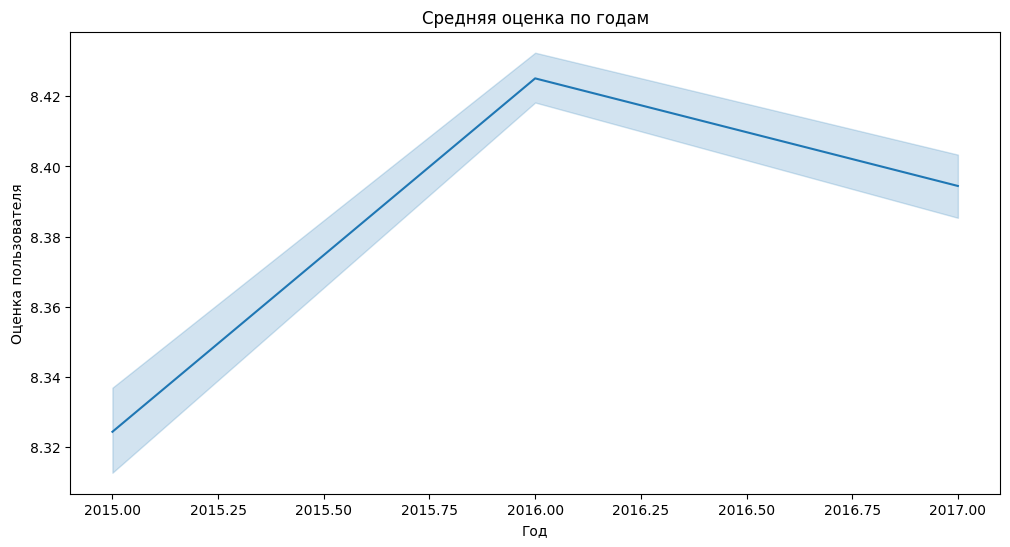

In [59]:
# Средняя оценка по месяцам
plt.figure(figsize=(12, 6))
sns.lineplot(x='review_month', y='reviewer_score', data=df_train_clear)
plt.title('Средняя оценка по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Оценка пользователя')
plt.show()

# Средняя оценка по годам
plt.figure(figsize=(12, 6))
sns.lineplot(x='review_year', y='reviewer_score', data=df_train_clear)
plt.title('Средняя оценка по годам')
plt.xlabel('Год')
plt.ylabel('Оценка пользователя')
plt.show()

### 4. Влияет ли национальность рецензента на его оценку?

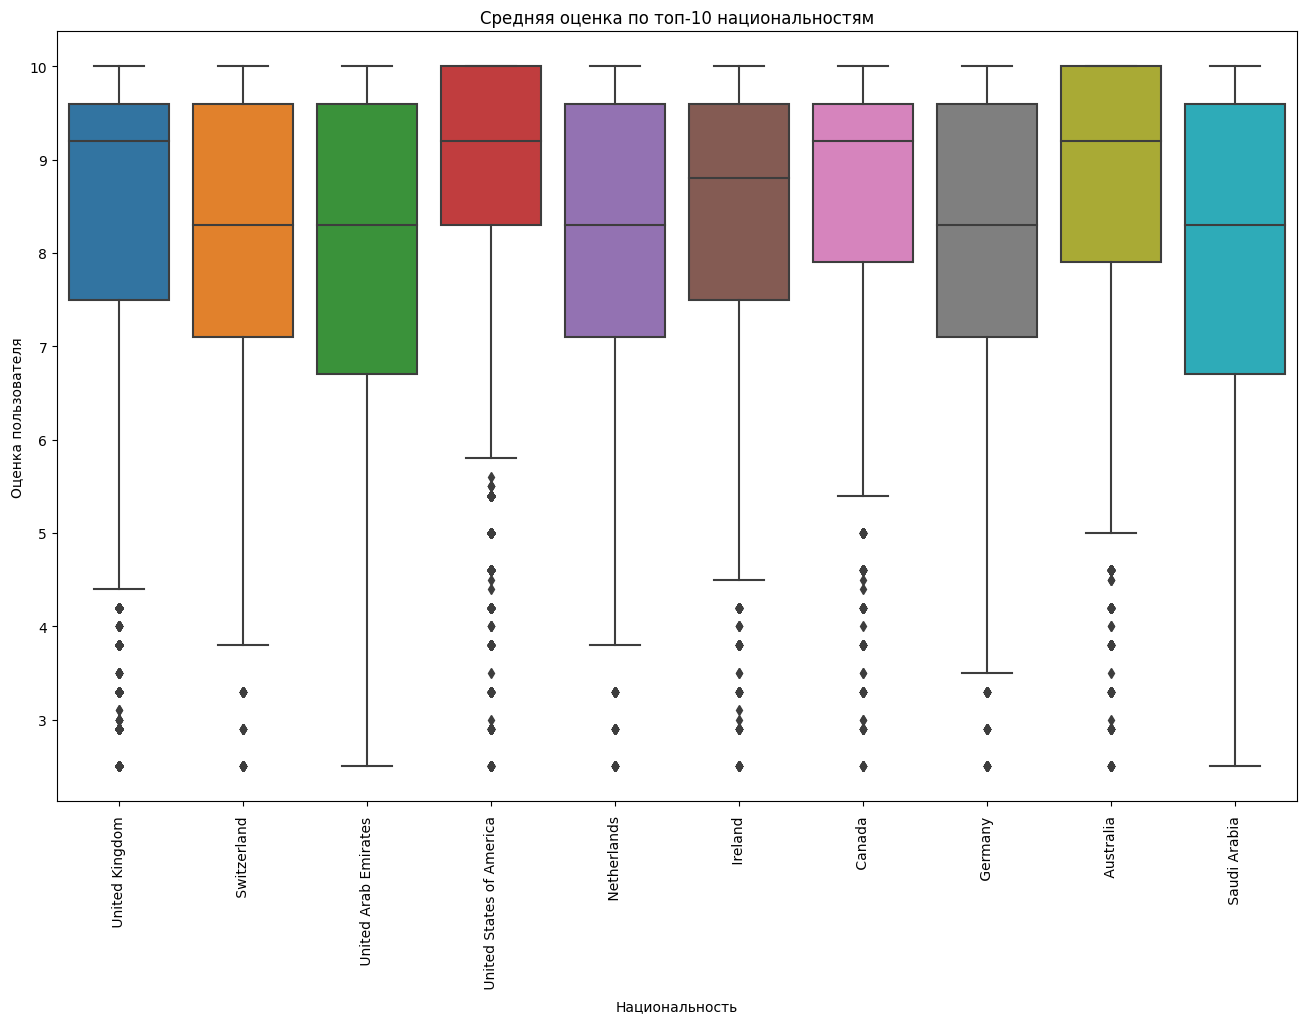

In [60]:
# Раскодируем обратно для графика
df_train_clear['reviewer_nationality'] = label_encoder_nationality.inverse_transform(df_train_clear['reviewer_nationality_encoded'])

# Считаем количество отзывов по каждой национальности
nationality_counts = df_train_clear['reviewer_nationality'].value_counts()

# Выберем топ-10 национальностей с наибольшим количеством отзывов
top_nationalities = nationality_counts.head(10).index

# Отфильтруем DataFrame, чтобы оставить только эти национальности
df_top_nationalities = df_train_clear[df_train_clear['reviewer_nationality'].isin(top_nationalities)]

# Построим boxplot для топ-10 национальностей
plt.figure(figsize=(16, 10))
sns.boxplot(x='reviewer_nationality', y='reviewer_score', data=df_top_nationalities)
plt.title('Средняя оценка по топ-10 национальностям')
plt.xlabel('Национальность')
plt.ylabel('Оценка пользователя')
plt.xticks(rotation=90)
plt.show()

In [61]:
df_train_clear.drop(columns=['reviewer_nationality'], inplace=True)

### Проведем статистические тесты

**Уровень альфа = 0.05**

#### 1. Связь между длиной отзыва и оценкой пользователя

**Вопрос**. Есть ли связь между длиной отзыва (положительного или отрицательного) и оценкой пользователя?

**Нулевая гипотеза (H0)**. Длина отзыва не влияет на оценку пользователя.
   
**Альтернативная гипотеза (H1)**. Длина отзыва влияет на оценку пользователя.

In [62]:
import scipy.stats as stats

In [63]:
alpha = 0.05

In [64]:
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))

In [65]:
data_neg = df_train_clear['negative_review_length']
data_rev = df_train_clear['reviewer_score']
data_pos = df_train_clear['positive_review_length']

# проводим тест Шапиро-Уилка
print('Для негативных отзывов:')
result = stats.shapiro(data_neg)
decision_normality(result[1])

print('Для позитивных отзывов:')
result = stats.shapiro(data_pos)
decision_normality(result[1])

print('Для оценки пользователей:')
result = stats.shapiro(data_rev)
decision_normality(result[1])

Для негативных отзывов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для позитивных отзывов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для оценки пользователей:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [66]:
_, p_value_negative_length = stats.wilcoxon(df_train_clear['negative_review_length'], df_train_clear['reviewer_score'])
print(f'p-значение: {p_value_negative_length}')
if p_value_negative_length < 0.05:
    print("Отвергаем нулевую гипотезу: длина отрицательного отзыва влияет на оценку пользователя.")
else:
    print("Не отвергаем нулевую гипотезу: длина отрицательного отзыва не влияет на оценку пользователя.")

# Проверка корреляции между длиной положительного отзыва и оценкой пользователя
_, p_value_positive_length = stats.wilcoxon(df_train_clear['positive_review_length'], df_train_clear['reviewer_score'])
print(f'p-значение: {p_value_positive_length}')
if p_value_positive_length < 0.05:
    print("Отвергаем нулевую гипотезу: длина положительного отзыва влияет на оценку пользователя.")
else:
    print("Не отвергаем нулевую гипотезу: длина положительного отзыва не влияет на оценку пользователя.")

p-значение: 0.0
Отвергаем нулевую гипотезу: длина отрицательного отзыва влияет на оценку пользователя.
p-значение: 0.0
Отвергаем нулевую гипотезу: длина положительного отзыва влияет на оценку пользователя.


#### 2. Влияние тональности отзывов на оценку пользователя

**Вопрос**. Как тональность отзывов (положительных и отрицательных) влияет на оценку пользователя?

**Нулевая гипотеза (H0)**. Тональность отзывов не влияет на оценку пользователя.
   
**Альтернативная гипотеза (H1)**. Тональность отзывов влияет на оценку пользователя.

In [67]:
data_neg = df_train_clear['negative_review_sentiment']
data_rev = df_train_clear['reviewer_score']
data_pos = df_train_clear['positive_review_sentiment']

# проводим тест Шапиро-Уилка
print('Для негативных отзывов:')
result = stats.shapiro(data_neg)
decision_normality(result[1])

print('Для позитивных отзывов:')
result = stats.shapiro(data_pos)
decision_normality(result[1])

print('Для оценки пользователей:')
result = stats.shapiro(data_rev)
decision_normality(result[1])

Для негативных отзывов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для позитивных отзывов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для оценки пользователей:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [68]:
# Проверка корреляции между тональностью отрицательного отзыва и оценкой пользователя
_, p_value_negative_sentiment = stats.wilcoxon(df_train_clear['negative_review_sentiment'], df_train_clear['reviewer_score'])
print(f'p-значение: {p_value_negative_sentiment}')
if p_value_negative_sentiment < 0.05:
    print("Отвергаем нулевую гипотезу: тональность отрицательного отзыва влияет на оценку пользователя.")
else:
    print("Не отвергаем нулевую гипотезу: тональность отрицательного отзыва не влияет на оценку пользователя.")

# Проверка корреляции между тональностью положительного отзыва и оценкой пользователя
_, p_value_positive_sentiment = stats.wilcoxon(df_train_clear['positive_review_sentiment'], df_train_clear['reviewer_score'])
print(f'p-значение: {p_value_positive_sentiment}')
if p_value_positive_sentiment < 0.05:
    print("Отвергаем нулевую гипотезу: тональность положительного отзыва влияет на оценку пользователя.")
else:
    print("Не отвергаем нулевую гипотезу: тональность положительного отзыва не влияет на оценку пользователя.")

p-значение: 0.0
Отвергаем нулевую гипотезу: тональность отрицательного отзыва влияет на оценку пользователя.
p-значение: 0.0
Отвергаем нулевую гипотезу: тональность положительного отзыва влияет на оценку пользователя.


#### 3. Средняя оценка по месяцам и годам

**Вопрос**. Меняется ли средняя оценка по месяцам и годам?

**Нулевая гипотеза (H0)**. Время написания отзыва (месяц или год) не влияет на оценку пользователя.
   
**Альтернативная гипотеза (H1)**. Время написания отзыва (месяц или год) влияет на оценку пользователя.

In [69]:
shapiro_month_stat, shapiro_month_p_value = stats.shapiro(df_train_clear['review_month'])
decision_normality(shapiro_month_p_value)

shapiro_year_stat, shapiro_year_p_value = stats.shapiro(df_train_clear['review_year'])
decision_normality(shapiro_year_p_value)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [70]:
kruskal_month = stats.kruskal(*[group["reviewer_score"].values for name, group in df_train_clear.groupby("review_month")])
print(f'p-значение={kruskal_month.pvalue}')
if kruskal_month.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу: средняя оценка зависит от месяца.")
else:
    print("Не отвергаем нулевую гипотезу: средняя оценка не зависит от месяца.")

# Краскел-Уоллис для оценок по годам
kruskal_year = stats.kruskal(*[group["reviewer_score"].values for name, group in df_train_clear.groupby("review_year")])
print(f'p-значение={kruskal_year.pvalue}')
if kruskal_year.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу: средняя оценка зависит от года.")
else:
    print("Не отвергаем нулевую гипотезу: средняя оценка не зависит от года.")

p-значение=1.969660161885147e-179
Отвергаем нулевую гипотезу: средняя оценка зависит от месяца.
p-значение=6.89311063761119e-55
Отвергаем нулевую гипотезу: средняя оценка зависит от года.


#### 4. Влияние национальности рецензента на его оценку

**Вопрос**. Влияет ли национальность рецензента на его оценку?

**Нулевая гипотеза (H0)**. Национальность рецензента не влияет на его оценку.
   
**Альтернативная гипотеза (H1)**. Национальность рецензента влияет на его оценку.

In [71]:
_, p_value = stats.shapiro(df_train_clear['reviewer_nationality_encoded'])
decision_normality(p_value)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


In [72]:
kruskal_nationality = stats.kruskal(*[group["reviewer_score"].values for name, group in df_train_clear.groupby("reviewer_nationality_encoded")])
print(f'Краскел-Уоллис для средней оценки по национальностям: H={kruskal_nationality.statistic}, p-значение={kruskal_nationality.pvalue}')
if kruskal_nationality.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу: средняя оценка зависит от национальности.")
else:
    print("Не отвергаем нулевую гипотезу: средняя оценка не зависит от национальности.")

Краскел-Уоллис для средней оценки по национальностям: H=8732.387540517113, p-значение=0.0
Отвергаем нулевую гипотезу: средняя оценка зависит от национальности.


### Итоговый вывод

После проведения статистических тестов и анализа данных мы пришли к следующим выводам:

1. **Средняя оценка зависит от национальности рецензента**. Статистический анализ показал, что средняя оценка, данная пользователем, значимо различается в зависимости от его национальности.
2. **Средняя оценка зависит от месяца, в котором был оставлен отзыв**. Данные показали, что средняя оценка меняется в зависимости от месяца, что может указывать на сезонные колебания в качестве обслуживания или настроении рецензентов.
3. **Средняя оценка зависит от года, в котором был оставлен отзыв**. Анализ продемонстрировал значимые различия в средних оценках по годам, что может отражать изменения в обслуживании или внешние факторы, влияющие на восприятие.
4. **Тональность отрицательного отзыва влияет на оценку пользователя**. Негативная тональность отзывов коррелирует с оценками пользователей, что ожидаемо.
5. **Тональность положительного отзыва влияет на оценку пользователя**. Положительная тональность отзывов также оказывает значимое влияние на оценки.
6. **Длина отрицательного отзыва влияет на оценку пользователя**. Чем длиннее отрицательный отзыв, тем больше он влияет на общую оценку.
7. **Длина положительного отзыва влияет на оценку пользователя**. Аналогично, длина положительного отзыва также значимо влияет на итоговую оценку пользователя.

## Тест с CatBoost

In [73]:
!pip install catboost

In [74]:
from catboost import CatBoostRegressor, cv, Pool
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error

In [75]:
# Подготовка данных
X = df_train_clear.drop(columns=['reviewer_score'])
y = df_train_clear['reviewer_score']

# Создание Pool для более быстрого обучения
data_pool = Pool(data=X, label=y)

# Инициализация модели CatBoost
model = CatBoostRegressor(loss_function='MAPE', thread_count=-1, verbose=300, task_type='GPU', devices='0:1')

# Встроенная кросс-валидация в CatBoost
cv_data = cv(
    data_pool,
    model.get_params(),
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
    stratified=False,
    verbose=300
)

# Средняя ошибка (MAPE) и её отклонение
mean_mape = np.mean(cv_data['test-MAPE-mean'])
std_mape = np.std(cv_data['test-MAPE-std'])
print(f'Средняя ошибка (MAPE) на кросс-валидации: {mean_mape * 100:.2f}%')
print(f'Отклонение ошибок (MAPE) на кросс-валидации: {std_mape * 100:.2f}%')

Training on fold [0/5]
0:	learn: 0.9995098	test: 0.9995079	best: 0.9995079 (0)	total: 31.2ms	remaining: 31.2s
300:	learn: 0.8525097	test: 0.8519856	best: 0.8519856 (300)	total: 5.3s	remaining: 12.3s
600:	learn: 0.7088844	test: 0.7079722	best: 0.7079722 (600)	total: 10.5s	remaining: 6.97s
900:	learn: 0.5814769	test: 0.5808432	best: 0.5808432 (900)	total: 15.7s	remaining: 1.73s
999:	learn: 0.5431791	test: 0.5426658	best: 0.5426658 (999)	total: 17.4s	remaining: 0us
bestTest = 0.5426657503
bestIteration = 999
Training on fold [1/5]
0:	learn: 0.9995092	test: 0.9995097	best: 0.9995097 (0)	total: 18.8ms	remaining: 18.8s
300:	learn: 0.8523290	test: 0.8525359	best: 0.8525359 (300)	total: 5.5s	remaining: 12.8s
600:	learn: 0.7086066	test: 0.7088959	best: 0.7088959 (600)	total: 10.9s	remaining: 7.25s
900:	learn: 0.5813592	test: 0.5815090	best: 0.5815090 (900)	total: 16.1s	remaining: 1.77s
999:	learn: 0.5430582	test: 0.5432047	best: 0.5432047 (999)	total: 17.9s	remaining: 0us
bestTest = 0.543204745

In [76]:
# Обучение модели на полном наборе данных
model.fit(X, y)

# Предсказание для вычисления итогового MAPE на всех данных
y_pred = model.predict(X)
mape = mean_absolute_percentage_error(y, y_pred)
print(f'MAPE на всех данных: {mape * 100:.2f}%')

0:	learn: 0.1941241	total: 11.7ms	remaining: 11.7s
300:	learn: 0.1567302	total: 1.53s	remaining: 3.57s
600:	learn: 0.1374575	total: 3.16s	remaining: 2.1s
900:	learn: 0.1299035	total: 5.11s	remaining: 561ms
999:	learn: 0.1285384	total: 5.7s	remaining: 0us
MAPE на всех данных: 12.85%


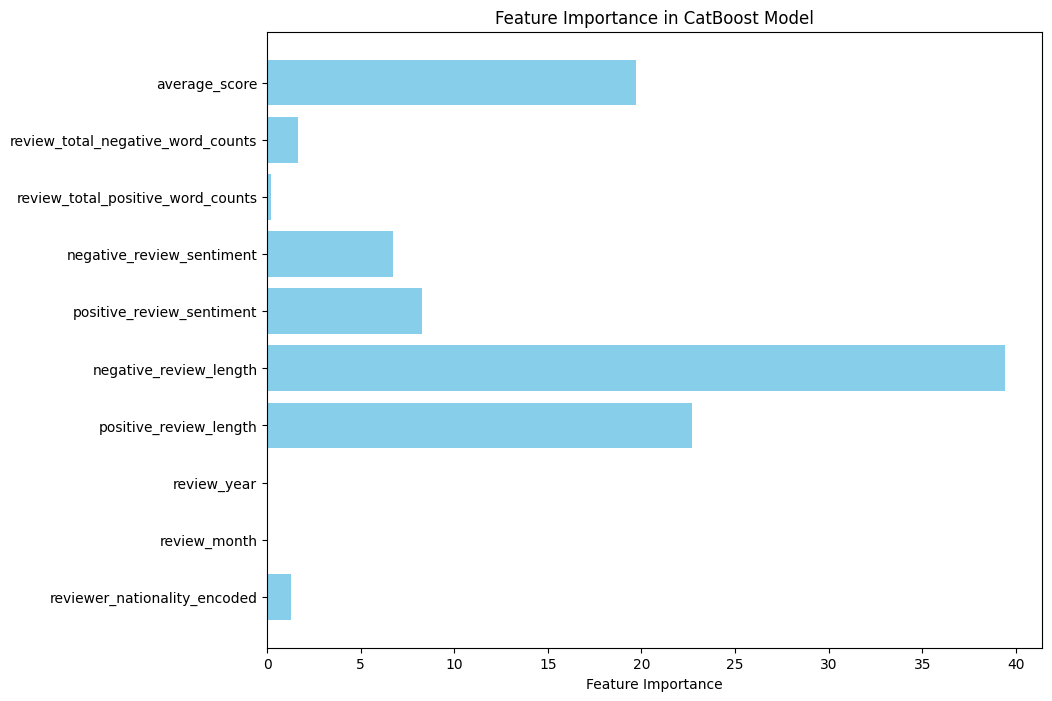

In [77]:
# Важность признаков
feature_importances = model.get_feature_importance(data_pool)
feature_names = X.columns

# Построение гистограммы важности признаков
plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [78]:
df_train_clear_3 = df_train_clear.drop(columns=['review_year', 'review_month'])

In [79]:
# Подготовка данных
X_2 = df_train_clear_3.drop(columns=['reviewer_score'])
y_2 = df_train_clear_3['reviewer_score']

# Создание Pool для более быстрого обучения
data_pool_2 = Pool(data=X_2, label=y_2)

# Инициализация модели CatBoost
model_2 = CatBoostRegressor(loss_function='MAPE', iterations=1500, thread_count=-1, verbose=300, task_type='GPU', devices='0:1')

# Встроенная кросс-валидация в CatBoost
cv_data_2 = cv(
    data_pool_2,
    model_2.get_params(),
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
    stratified=False,
    verbose=300
)

# Средняя ошибка (MAPE) и её отклонение
mean_mape = np.mean(cv_data_2['test-MAPE-mean'])
std_mape = np.std(cv_data_2['test-MAPE-std'])
print(f'Средняя ошибка (MAPE) на кросс-валидации: {mean_mape * 100:.2f}%')
print(f'Отклонение ошибок (MAPE) на кросс-валидации: {std_mape * 100:.2f}%')

Training on fold [0/5]
0:	learn: 0.9995087	test: 0.9995066	best: 0.9995066 (0)	total: 28.6ms	remaining: 42.9s
300:	learn: 0.8522171	test: 0.8516668	best: 0.8516668 (300)	total: 5.3s	remaining: 21.1s
600:	learn: 0.7087963	test: 0.7078412	best: 0.7078412 (600)	total: 10.4s	remaining: 15.6s
900:	learn: 0.5817060	test: 0.5810524	best: 0.5810524 (900)	total: 15.8s	remaining: 10.5s
1200:	learn: 0.4713898	test: 0.4711156	best: 0.4711156 (1200)	total: 21s	remaining: 5.22s
1499:	learn: 0.3774910	test: 0.3775068	best: 0.3775068 (1499)	total: 26.1s	remaining: 0us
bestTest = 0.377506822
bestIteration = 1499
Training on fold [1/5]
0:	learn: 0.9995084	test: 0.9995087	best: 0.9995087 (0)	total: 18.3ms	remaining: 27.4s
300:	learn: 0.8520239	test: 0.8522261	best: 0.8522261 (300)	total: 5.19s	remaining: 20.7s
600:	learn: 0.7085236	test: 0.7088135	best: 0.7088135 (600)	total: 10.4s	remaining: 15.6s
900:	learn: 0.5816353	test: 0.5817796	best: 0.5817796 (900)	total: 15.5s	remaining: 10.3s
1200:	learn: 0.47

In [80]:
# Обучение модели на полном наборе данных
model_2.fit(X_2, y_2)

# Предсказание для вычисления итогового MAPE на всех данных
y_pred_2 = model_2.predict(X_2)
mape = mean_absolute_percentage_error(y_2, y_pred_2)
print(f'MAPE на всех данных: {mape * 100:.2f}%')

0:	learn: 0.1941242	total: 7.68ms	remaining: 11.5s
300:	learn: 0.1567439	total: 1.58s	remaining: 6.29s
600:	learn: 0.1374630	total: 3.25s	remaining: 4.86s
900:	learn: 0.1299043	total: 4.58s	remaining: 3.05s
1200:	learn: 0.1266667	total: 5.83s	remaining: 1.45s
1499:	learn: 0.1250624	total: 7.08s	remaining: 0us
MAPE на всех данных: 12.51%


In [35]:
df_train_clear_2 = df_train.drop(['days_since_review', 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'tags'], axis=1)

In [40]:
# Определение категориальных признаков (столбцы с типом object)
categorical_features = ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_train_clear_2.drop(columns=[TARGET_NAME]), df_train_clear_2[TARGET_NAME], test_size=0.2, random_state=RANDOM_STATE)

# Создание пулов данных для CatBoost
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

# Инициализация модели CatBoost с использованием GPU
model_cat_1 = CatBoostRegressor(
    loss_function='MAPE',
    iterations=1500,
    thread_count=N_THREADS,
    random_seed=RANDOM_STATE,
    verbose=300,
    task_type='GPU',
    devices='0:1'
)

# Встроенная кросс-валидация в CatBoost
cv_data = cv(
    train_pool,
    model_cat_1.get_params(),
    fold_count=5,
    partition_random_seed=RANDOM_STATE,
    shuffle=True,
    stratified=False,
    verbose=300
)

# Средняя ошибка (MAPE) и её отклонение
mean_mape = np.mean(cv_data['test-MAPE-mean'])
std_mape = np.std(cv_data['test-MAPE-std'])
print(f'Средняя ошибка (MAPE) на кросс-валидации: {mean_mape * 100:.2f}%')
print(f'Отклонение ошибок (MAPE) на кросс-валидации: {std_mape * 100:.2f}%')

Training on fold [0/5]
0:	learn: 0.9995115	test: 0.9995099	best: 0.9995099 (0)	total: 64.9ms	remaining: 1m 37s
300:	learn: 0.8527883	test: 0.8525375	best: 0.8525375 (300)	total: 11.1s	remaining: 44.2s
600:	learn: 0.7088618	test: 0.7083773	best: 0.7083773 (600)	total: 21.9s	remaining: 32.7s
900:	learn: 0.5809592	test: 0.5804302	best: 0.5804302 (900)	total: 32.1s	remaining: 21.3s
1200:	learn: 0.4709771	test: 0.4703544	best: 0.4703544 (1200)	total: 42.3s	remaining: 10.5s
1499:	learn: 0.3779036	test: 0.3773854	best: 0.3773854 (1499)	total: 52.8s	remaining: 0us
bestTest = 0.3773853771
bestIteration = 1499
Training on fold [1/5]
0:	learn: 0.9995113	test: 0.9995091	best: 0.9995091 (0)	total: 39.6ms	remaining: 59.3s
300:	learn: 0.8528518	test: 0.8523165	best: 0.8523165 (300)	total: 10.9s	remaining: 43.5s
600:	learn: 0.7089998	test: 0.7079464	best: 0.7079464 (600)	total: 21.4s	remaining: 32s
900:	learn: 0.5810644	test: 0.5799247	best: 0.5799247 (900)	total: 31.7s	remaining: 21.1s
1200:	learn: 0

In [41]:
# Обучение модели на полном наборе данных
model_cat_1.fit(train_pool)

# Предсказание на тестовых данных
y_pred = model_cat_1.predict(test_pool)

# Оценка модели с использованием MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE на тестовых данных: {mape * 100:.2f}%')

0:	learn: 0.1942770	total: 21.1ms	remaining: 31.6s
300:	learn: 0.1590161	total: 5.99s	remaining: 23.9s
600:	learn: 0.1411112	total: 12s	remaining: 17.9s
900:	learn: 0.1340808	total: 18.1s	remaining: 12s
1200:	learn: 0.1305663	total: 24.6s	remaining: 6.12s
1499:	learn: 0.1289820	total: 31s	remaining: 0us
MAPE на тестовых данных: 12.82%


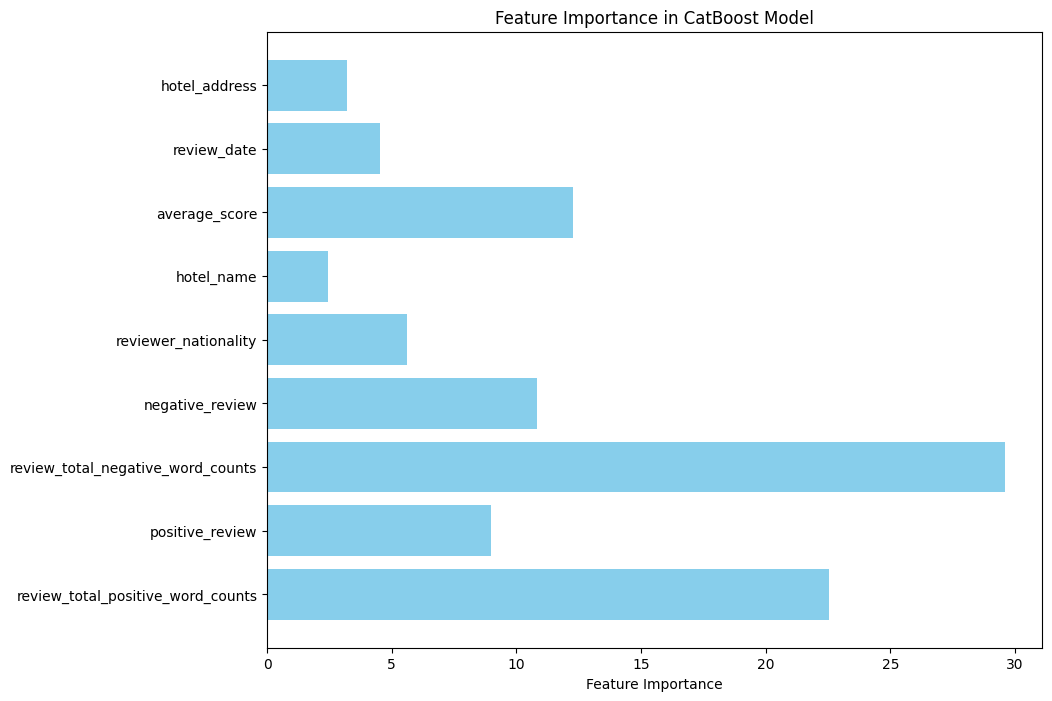

In [82]:
# Важность признаков
feature_importances = model_cat_1.get_feature_importance(train_pool)
feature_names = X_train.columns

# Построение гистограммы важности признаков
plt.figure(figsize=(10, 8))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

#### Обучаем с датасетом где сами преобразовывали фичи

In [83]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_transformed.drop(columns=[TARGET_NAME]), df_transformed[TARGET_NAME], test_size=0.2, random_state=RANDOM_STATE)

# Создание пулов данных для CatBoost
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

# Инициализация и обучение модели CatBoost
model_cat_2 = CatBoostRegressor(iterations=1500, thread_count=N_THREADS, random_seed=RANDOM_STATE, verbose=50)

model_cat_2.fit(train_pool)

# Предсказание на тестовых данных
y_pred = model_cat_2.predict(test_pool)

Learning rate set to 0.072848
0:	learn: 1.5940350	total: 80.6ms	remaining: 2m
50:	learn: 1.2295679	total: 3.5s	remaining: 1m 39s
100:	learn: 1.2227294	total: 6.88s	remaining: 1m 35s
150:	learn: 1.2203800	total: 9.84s	remaining: 1m 27s
200:	learn: 1.2181108	total: 13s	remaining: 1m 24s
250:	learn: 1.2160781	total: 15.9s	remaining: 1m 19s
300:	learn: 1.2142987	total: 18.8s	remaining: 1m 15s
350:	learn: 1.2126853	total: 22.1s	remaining: 1m 12s
400:	learn: 1.2110840	total: 24.9s	remaining: 1m 8s
450:	learn: 1.2094604	total: 27.8s	remaining: 1m 4s
500:	learn: 1.2079706	total: 30.6s	remaining: 1m 1s
550:	learn: 1.2065482	total: 33.5s	remaining: 57.6s
600:	learn: 1.2051427	total: 36.3s	remaining: 54.3s
650:	learn: 1.2036166	total: 39.2s	remaining: 51.2s
700:	learn: 1.2022921	total: 42s	remaining: 47.9s
750:	learn: 1.2009190	total: 44.9s	remaining: 44.7s
800:	learn: 1.1995821	total: 47.7s	remaining: 41.6s
850:	learn: 1.1982331	total: 50.6s	remaining: 38.6s
900:	learn: 1.1968986	total: 53.9s	re

In [84]:
# Оценка модели с использованием MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape * 100:.2f}%')

MAPE: 13.29%


### Отправка решения

In [99]:
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')

In [100]:
df_test['lat'] = df_test['lat'].fillna(df_test['lat'].median())
df_test['lng'] = df_test['lng'].fillna(df_test['lng'].median())

In [101]:
df_test['days_since_review'] = df_test['days_since_review'].str.replace(r'\D', '', regex=True).astype(int)

In [102]:
df_test['tags'] = df_test['tags'].apply(clean_tags)

In [103]:
df_test_clear = df_test.drop(['days_since_review', 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'tags'], axis=1)

In [104]:
test_pool2 = Pool(data=df_test_clear, cat_features=categorical_features)

# Предсказание на тестовых данных
submission_pred = model_cat_1.predict(test_pool2)

sample_submission['reviewer_score'] = submission_pred 
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.084,488440
1,7.477,274649
2,8.521,374688
3,9.620,404352
4,9.622,451596
5,8.720,302161
6,7.879,317079
7,7.830,13963
8,8.727,159785
9,7.648,195089


In [106]:
sample_submission.to_csv('submission.csv', index=False)